# Remove Climatological Mean Annual Cycle and Detrend Data - Version 5 (FOR DEBUGGING)<a id='top' class="tocSkip"> </a>
#### (Removing Data 7 degrees K from the Maximum Temperature)<a id='top' class="tocSkip"> </a>

***

**v5 explicitly creates a template object rather than using the default template as was done in v4. No attributes of the template object are altered from their default values. The default priority value for the "mean" attribute is 1 (see line 7 below).**

For this notebook, I (Holly Davis) used the mesalib version of the cdat v8.1 conda environment, which I've called cdat81-mesa.

***
***
**Note: We’ve determined that the mean value shown in the top left corner of each plot below, does not always match the correct mean value of the time series being plotted. Hence, the mean values stated on the plots should be ignored. We’ve reported this problem to the development team. The incorrect mean values on the plots do not affect the analysis described in this notebook which is correct.**

***

This tutorial shows how to use [CDAT](https://cdat.llnl.gov) to remove the climatological mean annual cycle and detrend data - a common procedure applied prior to detailed climate data analysis of monthly anomalies.

The data considered in this notebook are monthly-mean surface air temperatures gridded over the United States and spanning the years 1850 - 1990. The original dataset is complete, but it is artificially modified in this notebook by "masking" some values, yielding an incomplete dataset with some values "missing" (as is often encountered in analysis of climate data). The analysis procedure involves three major steps:

1. Remove the climatological annual cycle yielding monthly-mean departures.
2. Spatially average over the domain.
3. Remove the time-mean and the linear trend.

When there are missing values in the dataset (as in the sample calculations below), the final detrended time-series will depend on the order in which these steps are executed.  Here we examine options for detrending the data, and we show that slightly different results are generated depending on the order in which operations are performed.  More sophisticated treatments (not discussed here) involving appropriately weighting samples and collections of samples should be considered for datasets that only sparsely cover the time and space domains.


To [download this Jupyter Notebook](Detrend_data.ipynb), right click on the link and choose "Download Linked File As..." or "Save Link as...". Remember where you saved the downloaded file, which should have an .ipynb extension. (You'll need to launch the Jupyter notebook or JupyterLab instance from the location where you store the notebook file.)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-Notebook-and-Data" data-toc-modified-id="Prepare-Notebook-and-Data-1">Prepare Notebook and Data</a></span><ul class="toc-item"><li><span><a href="#Download-Data" data-toc-modified-id="Download-Data-1.1">Download Data</a></span></li><li><span><a href="#Open-Data-File,-Extract-Variable" data-toc-modified-id="Open-Data-File,-Extract-Variable-1.2">Open Data File, Extract Variable</a></span></li></ul></li><li><span><a href="#Data-Exploration" data-toc-modified-id="Data-Exploration-2">Data Exploration</a></span></li><li><span><a href="#Order-of-Operations-Matters" data-toc-modified-id="Order-of-Operations-Matters-3">Order of Operations Matters</a></span><ul class="toc-item"><li><span><a href="#Numerical-Example" data-toc-modified-id="Numerical-Example-3.1">Numerical Example</a></span></li><li><span><a href="#Removing-the-Climatological-Annual-Cycle" data-toc-modified-id="Removing-the-Climatological-Annual-Cycle-3.2">Removing the Climatological Annual Cycle</a></span><ul class="toc-item"><li><span><a href="#Processing-Option-1:-Remove-the-annual-cycle,-then-spatially-average-to-create-a-single-time-series" data-toc-modified-id="Processing-Option-1:-Remove-the-annual-cycle,-then-spatially-average-to-create-a-single-time-series-3.2.1">Processing Option 1: Remove the annual cycle, then spatially average to create a single time series</a></span></li><li><span><a href="#Processing-Option-2:-Spatially-average-data-to-obtain-a-single-time-series,-then-remove-the-annual-cycle" data-toc-modified-id="Processing-Option-2:-Spatially-average-data-to-obtain-a-single-time-series,-then-remove-the-annual-cycle-3.2.2">Processing Option 2: Spatially average data to obtain a single time-series, then remove the annual cycle</a></span></li></ul></li></ul></li><li><span><a href="#Detrend-Data" data-toc-modified-id="Detrend-Data-4">Detrend Data</a></span><ul class="toc-item"><li><span><a href="#Consider-Two-Options" data-toc-modified-id="Consider-Two-Options-4.1">Consider Two Options</a></span><ul class="toc-item"><li><span><a href="#Processing-Option-A:---Spatially-average-the-anomaly-fields-over-the-domain,-then-remove-the-trend-from-the-resulting-time-series." data-toc-modified-id="Processing-Option-A:---Spatially-average-the-anomaly-fields-over-the-domain,-then-remove-the-trend-from-the-resulting-time-series.-4.1.1">Processing Option A:   Spatially average the anomaly fields over the domain, then remove the trend from the resulting time-series.</a></span></li><li><span><a href="#Processing-Option-B:-Remove-the-trend-at-each-grid-cell,-then-spatially-average-the-results." data-toc-modified-id="Processing-Option-B:-Remove-the-trend-at-each-grid-cell,-then-spatially-average-the-results.-4.1.2">Processing Option B: Remove the trend at each grid cell, then spatially average the results.</a></span></li></ul></li></ul></li></ul></div>

# Prepare Notebook and Data
[Back to Top](#top)

In [1]:
from __future__ import print_function
import cdms2
import MV2
import genutil
import cdutil
import vcs
import os
import requests

## Download Data
The following CMIP5 NetCDF file contains Near-Surface Air Temperature data in degrees Kelvin (K) over North America. It is downloaded to the directory where this notebook is stored.

In [2]:
filename = 'tas_Amon_IPSL-CM5A-LR_1pctCO2_r1i1p1_185001-198912.nc'
if not os.path.exists(filename):
    r = requests.get("https://cdat.llnl.gov/cdat/sample_data/notebooks/{}".format(filename), stream=True)
    with open(filename,"wb") as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:  # filter local_filename keep-alive new chunks
                f.write(chunk)

## Open Data File, Extract Variable
The following two lines of code open the file just downloaded to your local computer (`filename`), extract data for the Near-Surface Air Temperature (`tas`), and assign it to the variable `data`.

In [3]:
f = cdms2.open(filename)

data = f("tas")

The following line of code uses the `.info()` method to allow us to take a quick look at the structure of the temperature data stored in the ```data``` variable.  

There are 1680 different time values which are measured as "days since 1850-01-01 00:00:00". The range of the time values is the difference between the last value (51084.5) and the first value (15.5) which equals 51069 days. If we divide this range (51069) by the number of intervals in the dataset (1680-1), we get (51069/(1680-1)) = 30.416 days, which is the average time duration for each data point. This tells us that we are working with monthly data.

The data cover 13 latitude bands and 16 longitude values over the United States (latitudes ~25.6 to ~48.3 and longitudes -123.75 to -67.5).

In [4]:
data.info()

*** Description of Slab tas ***
id: tas
shape: (1680, 13, 16)
filename: 
missing_value: 1e+20
comments: 
grid_name: <None>
grid_type: generic
time_statistic: 
long_name: Near-Surface Air Temperature
units: K
tileIndex: None
original_name: t2m
associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_atmos_fx_IPSL-CM5A-LR_1pctCO2_r0i0p0.nc areacella: areacella_fx_IPSL-CM5A-LR_1pctCO2_r0i0p0.nc
coordinates: height
standard_name: air_temperature
cell_methods: time: mean (interval: 30 minutes)
cell_measures: area: areacella
history: 2011-03-07T11:45:34Z altered by CMOR: Treated scalar dimension: 'height'. 2011-03-07T11:45:34Z altered by CMOR: replaced missing value flag (9.96921e+36) with standard missing value (1e+20). 2011-03-07T11:45:34Z altered by CMOR: Inverted axis: lat.
Grid has Python id 0x12936c588.
Gridtype: generic
Grid shape: (13, 16)
Order: yx
** Dimension 1 **
   id: time
   Designated a time axis.
   units:  days since 1850-01-01 00:00:0

# Data Exploration
[Back to Top](#top)

First, to get a feel for the data, let's spatially average the data over the entire domain to create a time series of the mean temperature for the region. In creating this time series, the `averager` function will take the temperature data for the entire region and spatially average it to yield a single temperature value as a function of time (i.e., the latitude and longitude dimensions are removed by this action, as shown with the `.shape` method.)

In [5]:
data_ts = genutil.averager(data, axis='xy', weights=['weighted','weighted'], combinewts=1)
data_ts.shape

/Users/davis278/miniconda3/envs/cdat81-mesa/lib/python3.6/site-packages/genutil/averager.py:629: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if wgt in ['equal', 'unweighted']:
/Users/davis278/miniconda3/envs/cdat81-mesa/lib/python3.6/site-packages/genutil/averager.py:667: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if dim_wt in ['equal', 'unweighted']:


(1680,)

In the cell above, we have specified that averaging over the longitude and latitude dimensions (x and y) should be performed by weighting by grid-cell area. Note that the "combinewts" option should also be included for correct area-weighting.

In the next line of code, let's plot this time series.

In [6]:
template = vcs.createtemplate()

In [7]:
template.list()

---------- Template (P) member (attribute) listings ----------
method = P
name = __template_228244133432748
orientation = 0
member =  file
     priority = 1
     x = 0.0500000007451
     y = 0.0130000002682
     texttable = default
     textorientation = default
member =  function
     priority = 1
     x = 0.0500000007451
     y = 0.0130000002682
     texttable = default
     textorientation = default
member =  logicalmask
     priority = 1
     x = 0.0500000007451
     y = 0.0329999998212
     texttable = default
     textorientation = default
member =  transformation
     priority = 1
     x = 0.0500000007451
     y = 0.0529999993742
     texttable = default
     textorientation = default
member =  source
     priority = 1
     x = 0.0500000007451
     y = 0.941999971867
     texttable = default
     textorientation = default
member =  dataname
     priority = 1
     x = 0.0500000007451
     y = 0.922999978065
     texttable = default
     textorientation = default
member =  title
 

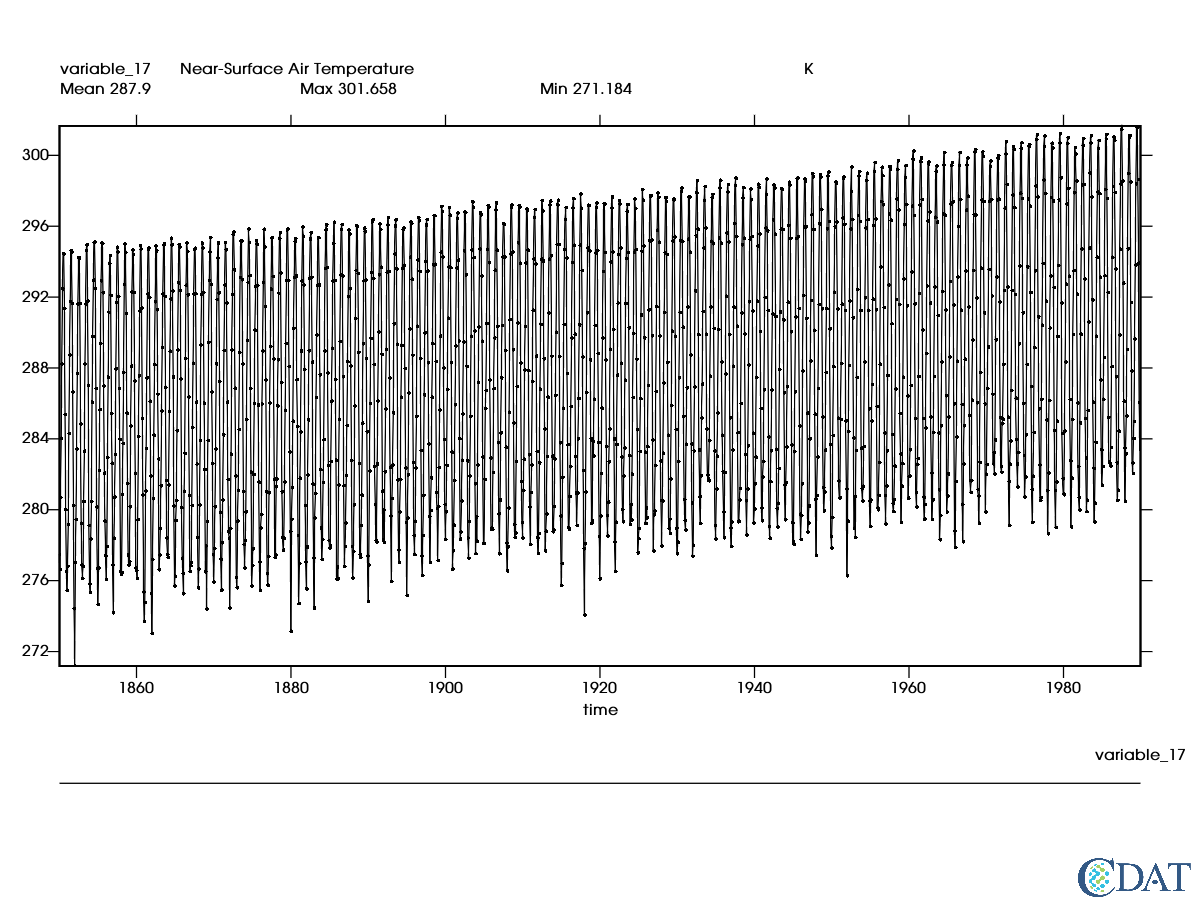

In [8]:
x = vcs.init(bg=True, geometry=(1200,900))
line = vcs.create1d()
line.markersize = .5
x.plot(data_ts, line, template)

The figure above shows that the surface temperature averaged over the U.S. is characterized by a pronounced annual cycle and a long term trend with some year to year variability.  The goal of the remainder of this analysis is remove both the climatological mean annual cycle and the long term trend.  This procedure leads to a filtered time series representing monthly temperature anomalies characterizing variability that cannot be explained by annual cycle forcing or any long-term changes in climate forcing.    

But first, let's look at a numerical example, which illustrates that the order in which you perform operations can make a difference when a dataset is incomplete (i.e., when a dataset includes "masked" or "missing" data).

# Order of Operations Matters

## Numerical Example
[Back to Top](#top)

If data are missing from a dataset, the order of operations can matter. The following is a numerical example of averaging values two different ways. 

Let's say we have the following dataset, which is a function of X and Y:

| | Y1 | Y2 | Y3 | Y4 |
|:---:|:---:|:---:|:---:|:---:|
| X1 | *3* | *4* | - | *7* |
| X2 | - | *5* | - | - |
| X3 | *1* | *2* | *5* | *5* |
| X4 | - | - | *6* | *4* |


Creating this dataset using a numpy array and using 999 where no values exist yields:

In [9]:
import numpy
array = numpy.array([[3,4,999,7],[999,5,999,999],[1,2,5,5],[999,999,6,4.]])
array

array([[  3.,   4., 999.,   7.],
       [999.,   5., 999., 999.],
       [  1.,   2.,   5.,   5.],
       [999., 999.,   6.,   4.]])

Masking the 999 values leads to the following:

In [10]:
masked = numpy.ma.masked_equal(array, 999.)
masked

masked_array(
  data=[[3.0, 4.0, --, 7.0],
        [--, 5.0, --, --],
        [1.0, 2.0, 5.0, 5.0],
        [--, --, 6.0, 4.0]],
  mask=[[False, False,  True, False],
        [ True, False,  True,  True],
        [False, False, False, False],
        [ True,  True, False, False]],
  fill_value=999.0)

**If we average over Y first, then average over X, we get (4.667 + 5.000 + 3.250 + 5.000) / 4 = 4.479**

| | Y1 | Y2 | Y3 | Y4 | Average |
|---|---|---|---|---|---|
| X1 | *3* | *4* | - | *7* | **4.667**
| X2 | - | *5* | - | - | **5.000**
| X3 | *1* | *2* | *5* | *5* | **3.250**
| X4 | - | - | *6* | *4* | **5.000**
| Average |  |  |  |  | **4.479**

Verifying this with code gives:

In [11]:
a = numpy.ma.average(numpy.ma.average(masked, axis=-1))
print ("Y, X:", "{0:.3f}".format(a)) 

Y, X: 4.479


**If we average over X first, then over Y, we get (2.000 + 3.667 + 5.500 + 5.333) / 4 = 4.125**

| | Y1 | Y2 | Y3 | Y4 | Average |
|---|---|---|---|---|---|
| X1 | *3* | *4* | - | *7* | 
| X2 | - | *5* | - | - | 
| X3 | *1* | *2* | *5* | *5* | 
| X4 | - | - | *6* | *4* | 
| Average | **2.000** | **3.667** | **5.500** | **5.333** | **4.125**

Verifying this with code yields:

In [12]:
b = numpy.ma.average(numpy.ma.average(masked, axis=0))
print ("X, Y:", "{0:.3f}".format(b)) 

X, Y: 4.125


**Finally, if we average using all 16 cells at once (but, of course, exclude those with missing data), we get (3 + 4 + 7 + 5 + 1 + 2 + 5 + 5 + 6 + 4) / 10 = 4.200**

In [13]:
c = numpy.ma.average(numpy.ma.average(masked))
print ("All:", "{0:.3f}".format(c)) 

All: 4.200


We get three different overall means (4.479, 4.125, or 4.200) depending on our processing choices (specifically the order of operations).  (Note that with appropriate weighting, which is *not* done here, a consistent mean *can* be obtained, independent of the order of operations. From the first example of averaging over Y, then X, since the total number of values in the dataset is 10, the proper weighting would be: 4.667 \* 3/10 + 5.000 \* 1/10 + 3.250 \* 4/10 + 5.000 \* 2/10 = 4.200.)  

When additional processing steps are involved, ordering can affect results in more complex ways, as in the next example.

## Removing the Climatological Annual Cycle
[Back to Top](#top)

Before detrending a time series, it is often best to filter it by removing the climatological mean annual cycle; in fact, this may be a requirement for particular types of analyses. In the case of a time series that does not span an integral/non-fractional representative number of years, an accurate determination of the trend of interest may require removal of the climatological mean annual cycle. To see why, consider a temperature time series starting in January and ending in July a year and a half later (i.e., *not* an integral number of years). Over Northern Hemisphere continents with a large annual cycle, the ending temperature would be much higher than the beginning temperature simply due to the usual seasonal changes in temperature. A linear fit to the time-series would result in a trend that would not reflect any real change in climate but just the particulars of the time period treated. To avoid such artificial trends, one should first remove the climatological annual cycle.

The surface temperature data considered earlier has no missing data, but more often than not observational datasets are incomplete. For purposes of illustration, we therefore will first modify the original surface temperature dataset by designating certain values as "missing". Specifically, we'll treat as "missing" (i.e., delete or mask) all data values that are within 7 degrees of the maximum temperature (`data.max()-7`) and store the result in `datamskd`.

In [14]:
datamskd = MV2.masked_greater(data, data.max()-7)

***Karl thinks it would be good to plot here (as a function of time) the number of grid cells with missing data.  Would that be difficult?  This would help in interpreting the later time-series.***

In [15]:
# code for plotting number of grid cells w/ missing data as a function of time.

We now consider what order to carry out the two-step operation needed to remove the climatological mean annual cycle:

1. Remove the climatological annual cycle yielding monthly-mean departures.
2. Spatially average over the domain.

We examine the two ordering options, with steps performed in the order shown above and then in the reverse order.

### Processing Option 1: Remove the annual cycle, then spatially average to create a single time series
[Back to Top](#top)

First at each location (grid cell) we will remove the climatological mean annual cycle to produce monthly mean departures or anomalies relative to the climatological annual cycle. Then we will spatially average the anomalies to produce a time-series of regional-mean anomalies.

In the next line of code, the `ANNUALCYCLE.departures` calculates the average monthly temperature value for each of the 12 months in a year over the complete time period for each location in the input data file and determines the departure of each temperature (at each time and location) from this average (i.e., "climatological") monthly value.

For example, once an average January value for the entire dataset has been calculated, each January value in the dataset is subtracted from that average January value to yield a series of January departures for each year in the data set. Since there are 1680 months in the dataset, there are 1680/12 = 140 years of data, and therefore 140 January departures. Since there are 140 Februaries, 140 Marches, etc. there are 140 departures x 12 months = 1680 departures for each location in the dataset, as the `.shape` method shows (1680 departure values by 13 latitude bands, by 16 longitude values).

In [16]:
datamskd_departures = cdutil.times.ANNUALCYCLE.departures(datamskd) # extract the departures of the masked data.

In [17]:
datamskd_departures.shape

(1680, 13, 16)

Now that we have a time series of monthly departures at each grid cell, we can spatially average them over the entire domain to obtain a single area-weighted time-series for the regional-mean monthly anomalies:

In [18]:
datamskd_departures_ts = genutil.averager(datamskd_departures, axis='xy', weights=['weighted','weighted'], combinewts=1) # create time series of the masked data departures.

Using the `.shape` method below verifies that the resulting spatially averaged data no longer have latitude and longitude information.

In [19]:
datamskd_departures_ts.shape

(1680,)

Let's plot the resulting time series of the departures (i.e. the result of removing the annual cycle before averaging spatially).

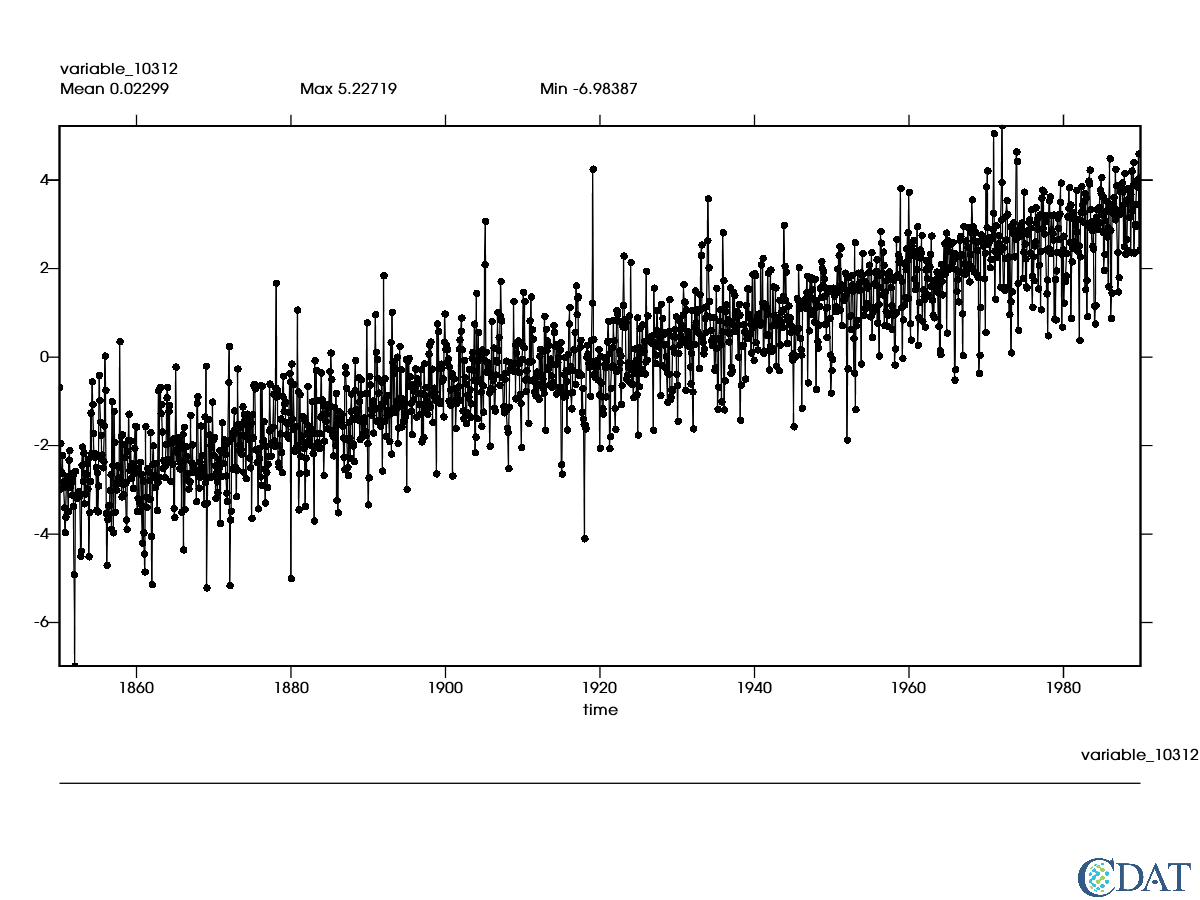

In [20]:
x = vcs.init(bg=True, geometry=(1200,900))
x.clear()
x.plot(datamskd_departures_ts, template)

Notice how, with the annual cycle removed, it is easier to see the trend and which months are anomalously warm or cold (compared to the climatological mean temperature).

It should be noted that with the order of operations executed under this option, we cannot expect the mean of the anomalies for a given month of the year summed over all years to be exactly zero. In the case considered here, for example, the climatological monthly mean anomalies are:

In [21]:
# Format the monthly mean anomaly data to show 5 digits after the decimal point.
numpy.set_printoptions(precision=5, formatter={'float': '{: 0.5f}'.format})

In [22]:
print(cdutil.times.ANNUALCYCLE.climatology(datamskd_departures_ts))

[ 0.00000 -0.00000  0.00000 -0.00000  0.01006  0.05874  0.09536  0.09576
  0.01505 -0.00000  0.00000  0.00000]


Although for any *individual* cell the anomalies do sum to zero for each month of the year, when the anomalies are spatially averaged and there are missing values this cannot be guaranteed. This is because when there are missing values, the order of averaging data sequentially over two dimensions can depend on the order it is done, as demonstrated earlier. This means that under Processing Option 1, additional care must be taken in calculating the anomalies. Although applying appropriate weighting during the averaging procedures (over time and over space) can remedy the problem, an easier solution is to remove a mean value (over all years for a given month of the year) from that month's temperature anomaly (`datmskd_departures_ts`) to obtain anomalies (`datmskd_departures_ts_corrected`) with means of zero:

In [23]:
datamskd_departures_ts_corrected = cdutil.times.ANNUALCYCLE.departures(datamskd_departures_ts)

In [24]:
datamskd_departures_ts_corrected.shape

(1680,)

In [25]:
print(cdutil.times.ANNUALCYCLE.climatology(datamskd_departures_ts_corrected))

[ 0.00000  0.00000 -0.00000  0.00000 -0.00000  0.00000  0.00000  0.00000
 -0.00000  0.00000  0.00000 -0.00000]


The following 3 lines of code are left in for DEBUGGING purposes:

In [26]:
print(genutil.averager(datamskd_departures_ts_corrected))

-1.4238664607012576e-16


In [27]:
print(genutil.averager(datamskd_departures_ts_corrected, weights='unweighted'))

-1.3534147347811433e-16


In [28]:
print(genutil.averager(datamskd_departures_ts_corrected, weights='weighted'))

-1.4238664607012576e-16


The time series mean should now be zero (within the limits of machine precision):

In [29]:
print(numpy.mean(datamskd_departures_ts_corrected))
#print("{0:.5f}".format(numpy.mean(datamskd_departures_ts_corrected)))

-1.3534147347811433e-16


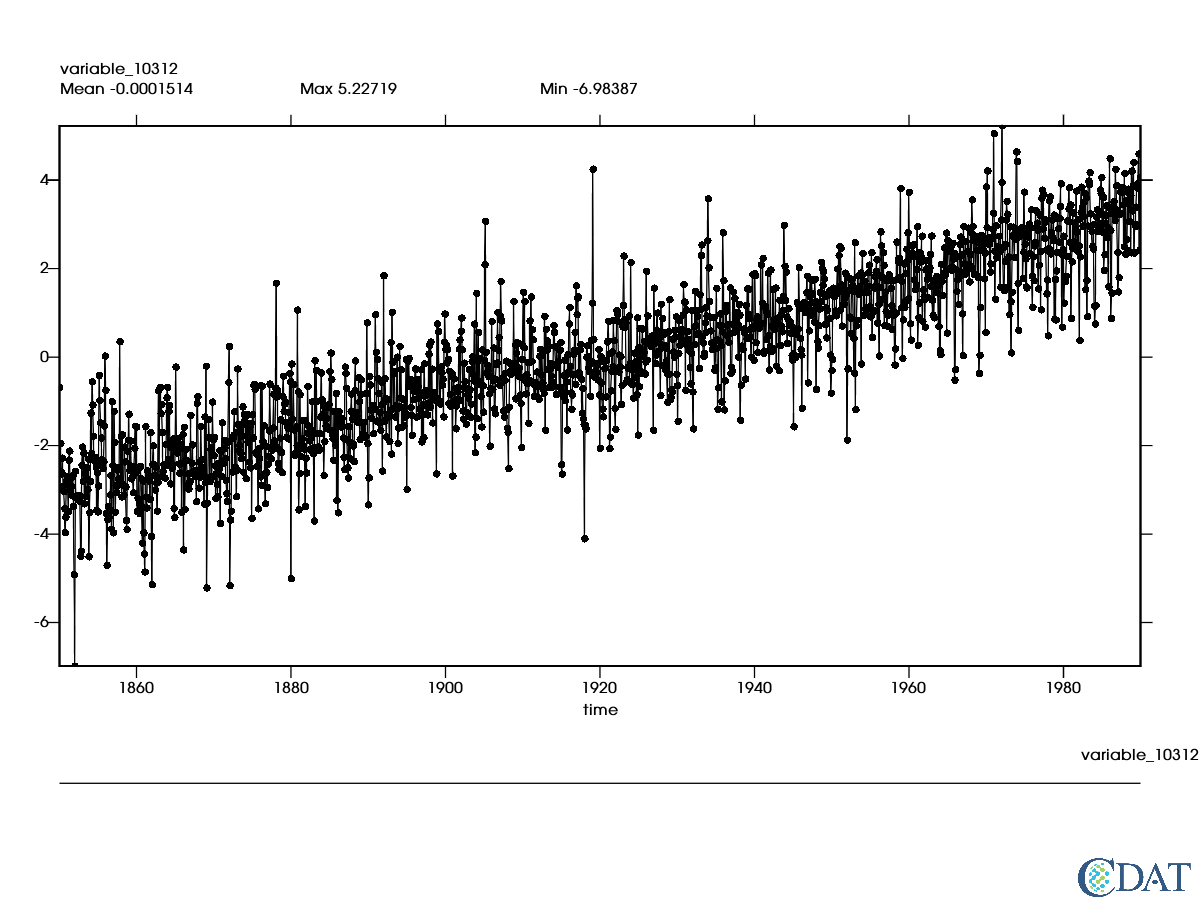

In [30]:
x.clear()
x.plot(datamskd_departures_ts_corrected, template)

### Processing Option 2: Spatially average data to obtain a single time-series, then remove the annual cycle
[Back to Top](#top)

Now let's reverse the order of performing the operations. We first calculate the spatially-averaged time series and then remove the annual cycle.

We calculate the time series characterizing area-mean temperature for the masked dataset by spatially averaging the temperature values over all latitude and longitude locations to give a single global temperature time series. (Again, the `.shape` method, shows we are looking at 1680 values with no latitude or longitude, as expected.)

In [31]:
datamskd_ts = genutil.averager(datamskd, axis='xy', weights=['weighted','weighted'], combinewts=1)

In [32]:
datamskd_ts.shape

(1680,)

Let's take a look at this time series. Note that the trend and the annual cycle are similar but not identical to what we saw with the unmasked data. In particular the maximum value of the spatial mean (considering all times) is lower than before (300.556 now compared to 301.658 for the unmasked data). This is because temperatures at individual grid cells that are within 7 K of the maximum temperature have been eliminated from consideration ("masked").

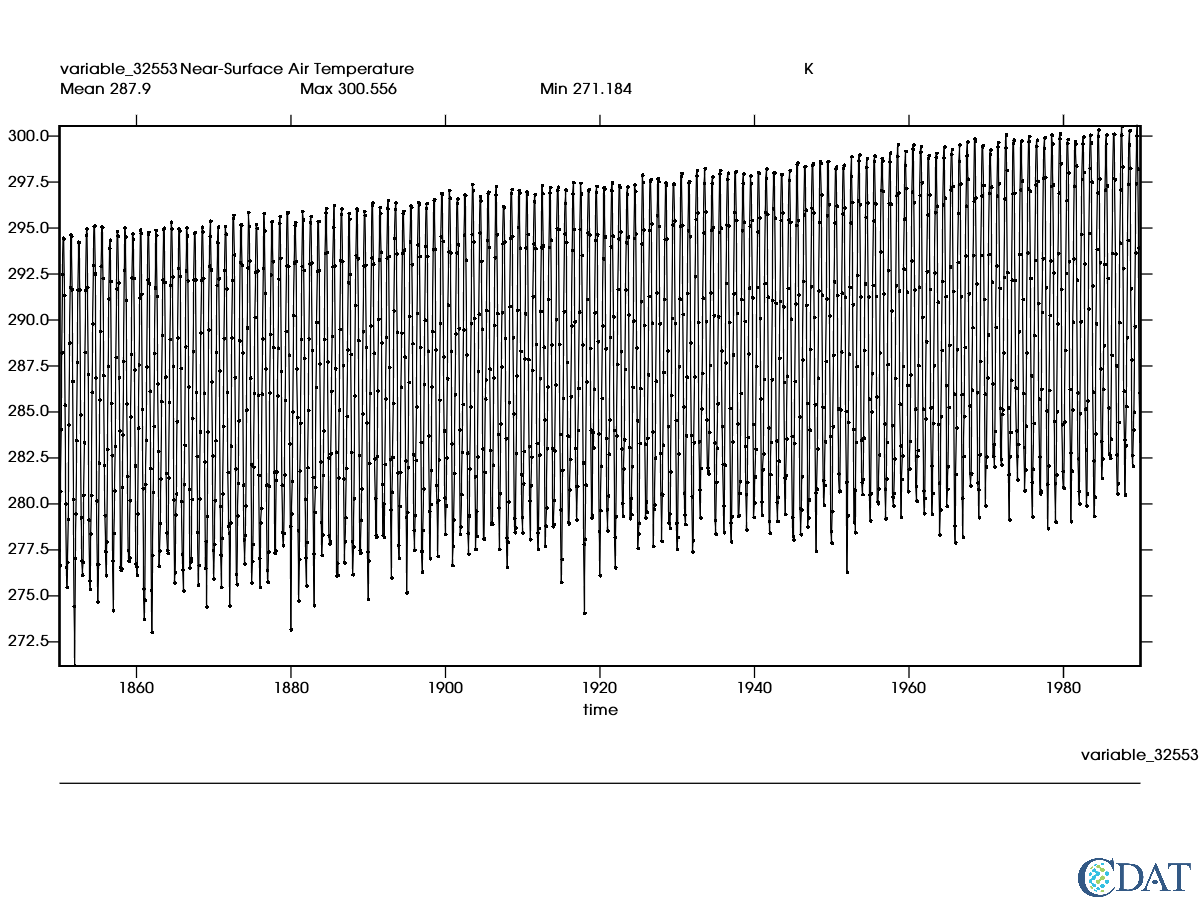

In [33]:
x = vcs.init(bg=True, geometry=(1200,900))
line = vcs.create1d()
line.markersize = .5
x.plot(datamskd_ts, line, template)

Next we'll remove the annual cycle using the `ANNUALCYCLE.departures` method as we did in executing Option 1 above. Again, the method calculates an average temperature value for each month of the year and determines the departure of the temperature at each time value from the average monthly temperature, effectively removing the annual cycle from the data.

In [34]:
datamskd_ts_departures = cdutil.times.ANNUALCYCLE.departures(datamskd_ts)
datamskd_ts_departures.shape

(1680,)

In [35]:
print(cdutil.times.ANNUALCYCLE.climatology(datamskd_ts_departures)) # All 12 annual cycle values should now be 0

[ 0.00000  0.00000  0.00000  0.00000  0.00000 -0.00000 -0.00000  0.00000
 -0.00000 -0.00000 -0.00000  0.00000]


The following 3 lines of code are left in for DEBUGGING purposes:

In [36]:
print(genutil.averager(datamskd_ts_departures))

4.2715993821037725e-15


In [37]:
print(genutil.averager(datamskd_ts_departures, weights='unweighted'))

4.0602442043434294e-15


In [38]:
print(genutil.averager(datamskd_ts_departures, weights='weighted'))

4.2715993821037725e-15


The time series mean should be zero (within the limits of machine precision):

In [39]:
print(numpy.mean(datamskd_ts_departures))
#print("{0:.5f}".format(numpy.mean(datamskd_ts_departures)))

4.0602442043434294e-15


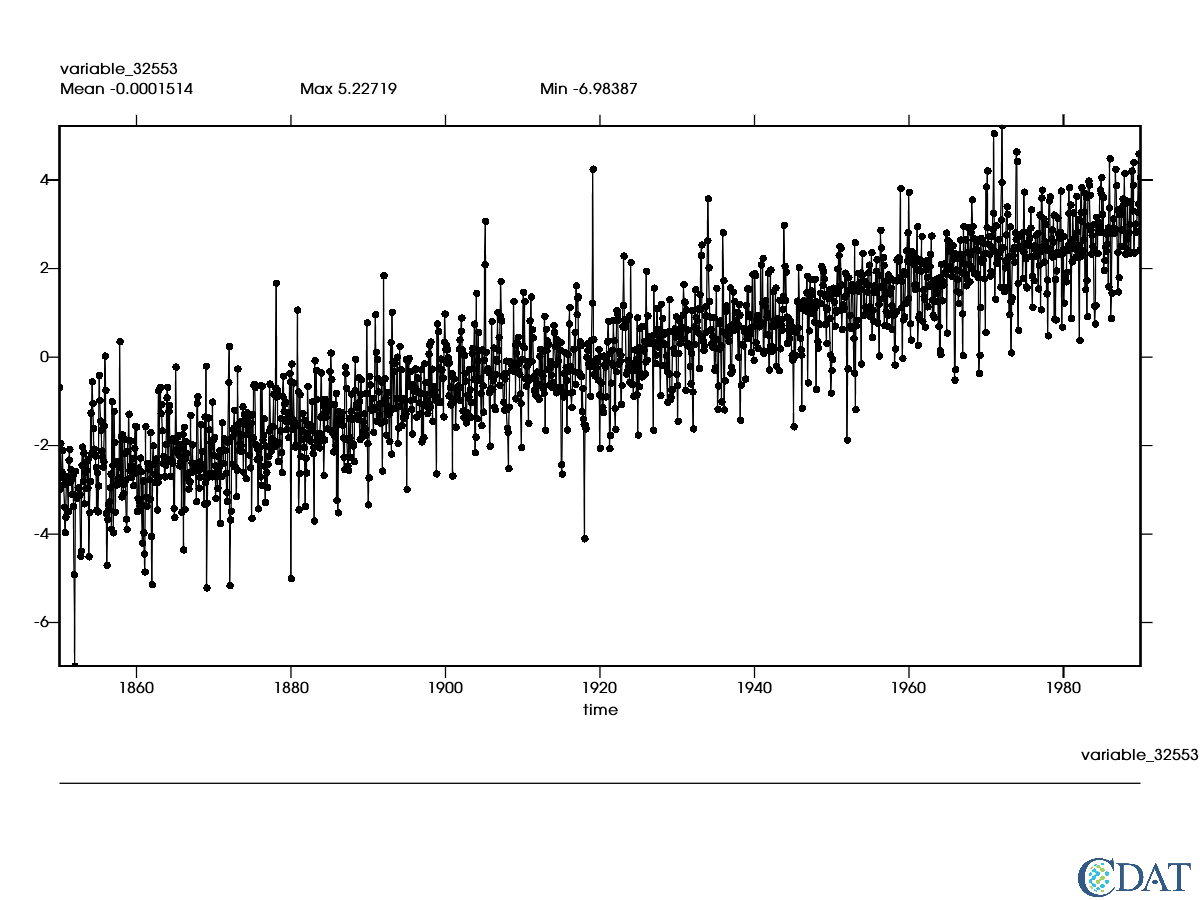

In [40]:
x.clear()
x.plot(datamskd_ts_departures, template)

It is difficult to visually detect any difference between the time series produced by Options 1 and 2, so let's plot their difference: `datamskd_departures_ts_corrected` (remove annual cycle at each grid cell, then spatially average to create a single time series) minus `datamskd_ts_departures` (spatially average to create a single time series, then remove annual cycle). This is the difference between Processing Option 1 and Option 2.

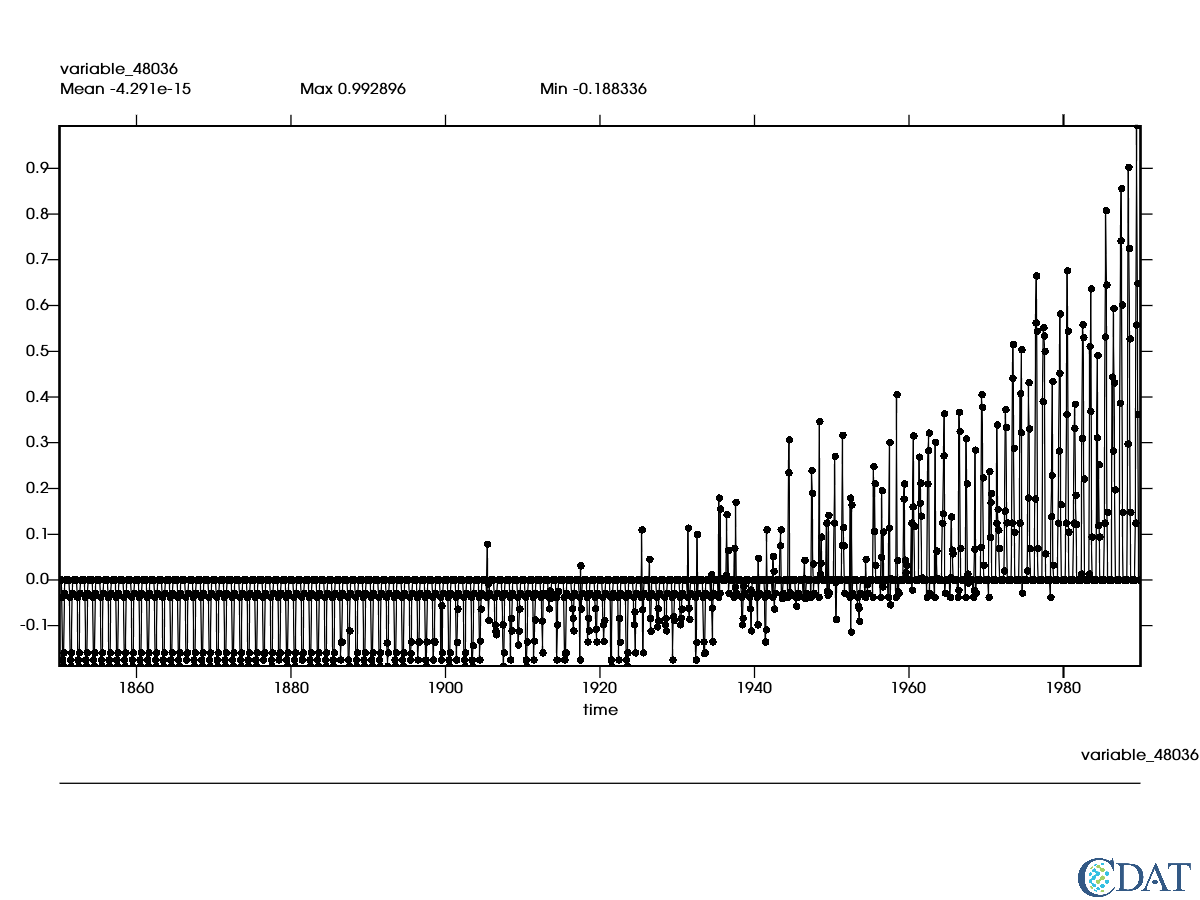

In [41]:
x.clear()
x.plot(datamskd_departures_ts_corrected - datamskd_ts_departures, template)

The plot above illustrates that the order of operations matters because there are missing data. The two time series are slightly different in some of the warmer (i.e., later) years, where data values may be "missing" because they exceed the temperature threshold (7 degrees cooler than the maximum temperature). If the order of operations did not matter (as in datasets without missing data), the two time series would be identical.

For the case considered above, computing the area mean time-series before removing the climatological annual cycle ("Processing Option 2") can be misleading. Recall that the missing data occur in the warmest part of the domain during the warmest part of the year. When these values are eliminated (i.e. designated as "missing"), we reduce the regional mean (for months with missing data), leading to an artificially cool month for that time of year (i.e., the regional-mean anomaly can become negative solely because the warm temperatures are missing over some of the region during that month). This explains why there are some positive differences in the latter part of the time series. The very small negative differences at other times simply are required to maintain a time mean of zero. Note that if the values were "missing" for a given grid cell every year at the same time of year, then they would not affect the regional mean and would not lead to unrealistic anomalies, but the values are only missing in the later part of the dataset (due to the long-term warming trend).

In contrast, "Processing Option 1" first removes the climatological annual cycle at each grid cell. Now the departures reflect true anomalies from the normal monthly temperature everywhere, and when they are spatially averaged, the result usually better represents the true regional mean anomalies.

Although Option 1 is clearly better in this case, in general, the user must consider the data being analyzed and the purpose for which the analysis is being performed to guide the choice of analysis options.

# Detrend Data
[Back to Top](#top)

We now will apply standard linear regression formulas to compute the slope (a) and intercept (b) of the trend line: T = a\*t + b where T = temperature departures (from the climatological annual cycle) and t = time, and then remove the trend from the data.

## Consider Two Options

Starting with the modified temperature dataset that includes "missing" values, we will again consider how the order of operations affects the result of removing the trend.  **Under both options below, the first step is to remove the climatological mean annual cycle from the time series of each grid cell (obtaining `datamskd_departures`), as was done in the first step performed under Option 1 above.**  Then we must decide which of the following processing procedures is most appropriate for a particular application: 

- Processing Option A: Spatially average the anomaly fields over the domain and remove the trend from the resulting time-series.
- Processing Option B: Remove the trend from the anomaly time series at each grid cell and then spatially average the results.

Under Option B, the resulting time-series may include a residual trend (and a residual non-zero mean), so an additional refinement should be applied to obtain a true anomaly field that has been fully detrended and has zero mean.

### Processing Option A:   Spatially average the anomaly fields over the domain, then remove the trend from the resulting time-series.

We begin by executing all the steps under Option 1 above to obtain `datamskd_departures_ts_corrected`. Now to detrend this anomaly time series, we must obtain the regression coefficients (slope and intercept) and then subtract the fitted linear trend from the original anomaly time series. We first apply a function to calculate the slope and intercept (with each month given equal weighting in the regression fit):

In [42]:
slope_ts, intercept_ts = genutil.statistics.linearregression(datamskd_departures_ts_corrected, axis="t")

In [43]:
datamskd_departures_ts_corrected.shape

(1680,)

Now we can remove the trend from the `datamskd_departures_ts_corrected` by subtracting the trend line after extracting the vector of times constituting the time axis for the data.

First extract the times:

In [44]:
times = MV2.array(datamskd.getTime()[:])
times.setAxis(0, datamskd.getTime())
times.shape

(1680,)

Now remove the trend:

In [45]:
datamskd_departures_ts_corrected_detrend = datamskd_departures_ts_corrected - times * slope_ts - intercept_ts
datamskd_departures_ts_corrected_detrend.shape

(1680,)

The time series mean should be zero (within the limits of machine precision):

In [46]:
print(numpy.mean(datamskd_departures_ts_corrected_detrend))
#print("{0:.5f}".format(numpy.mean(datamskd_departures_ts_corrected_detrend)))

-3.552713678800501e-16


The following 6 lines should be removed after DEBUGGING is complete.

In [47]:
print(genutil.averager(datamskd_departures_ts_corrected_detrend, weights='unweighted'))

-3.552713678800501e-16


In [48]:
print(genutil.averager(datamskd_departures_ts_corrected_detrend, weights='weighted'))

-9.303302636101774e-05


In [49]:
print(genutil.averager(datamskd_departures_ts_corrected_detrend))

-9.303302636101774e-05


In [50]:
print(cdutil.averager(datamskd_departures_ts_corrected_detrend, weights='unweighted'))

-3.552713678800501e-16


In [51]:
print(cdutil.averager(datamskd_departures_ts_corrected_detrend, weights='weighted'))

-9.303302636101774e-05


In [52]:
print(cdutil.averager(datamskd_departures_ts_corrected_detrend))

-9.303302636101774e-05


Plotting the resulting time series yields:

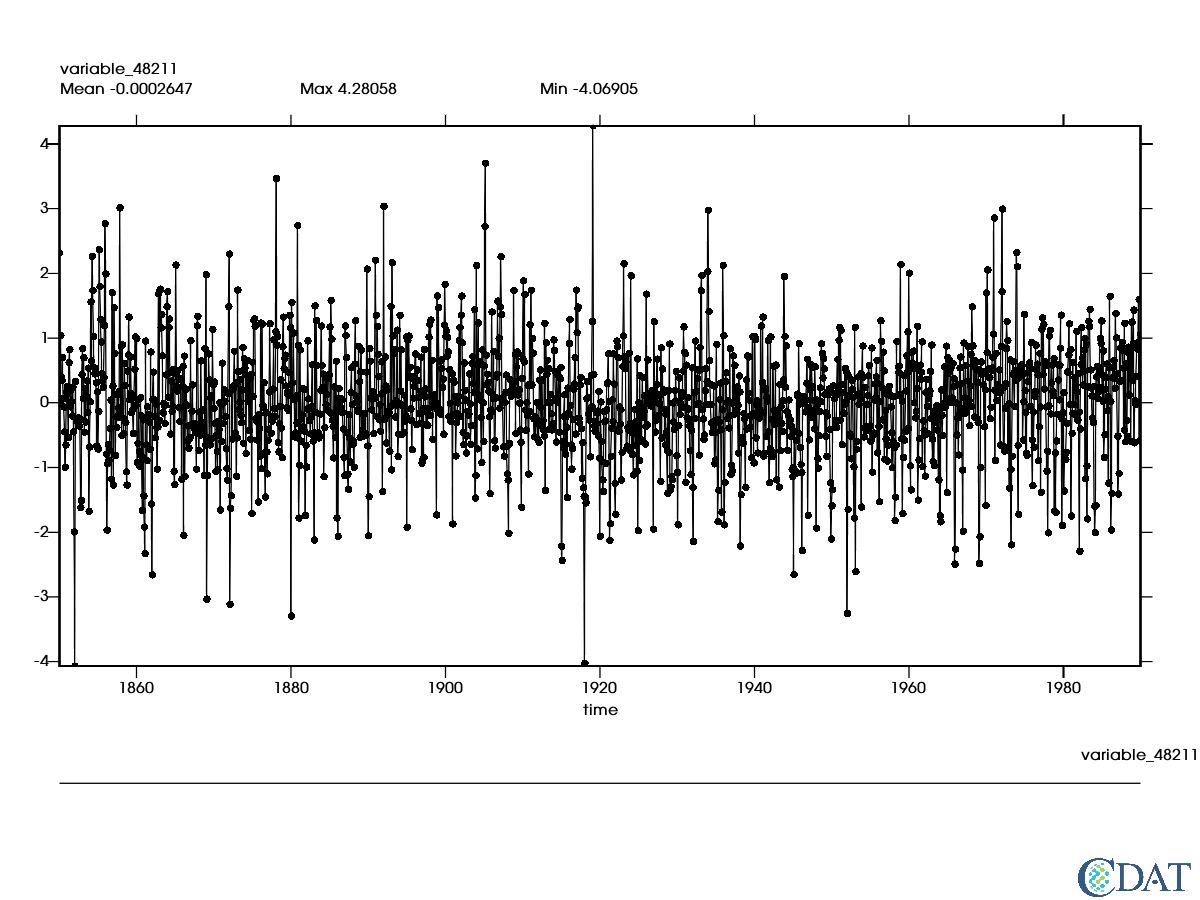

In [53]:
x.clear()
x.plot(datamskd_departures_ts_corrected_detrend, template)

### Processing Option B: Remove the trend at each grid cell, then spatially average the results.
[Back to Top](#top)

We now reverse the order of operations performed under Option A. First, for each grid cell we compute the regression coefficients (slopes and intercepts). We then remove the trends at each cell before computing an estimate of the regional mean anomaly time series. Because there is missing data, this time series will generally have a residual trend and non-zero mean, which must be adjusted in a final step to obtain a fully detrended time-series with zero mean.

We calculate the regression coefficients for each grid cell, starting with the data from which the climatological annual cycle has been removed (`datamskd_departures`) calculated in the first step of Option 1:

In [54]:
slope, intercept = genutil.statistics.linearregression(datamskd_departures, axis="t")
print("Shapes: slope {}, intercept {}".format(slope.shape, intercept.shape))

Shapes: slope (13, 16), intercept (13, 16)


Next, for each grid cell we subtract the regression line from the departure time series on which it is based (`datamskd_departures`) to obtain a detrended time series of anomalies. In general, we cannot simply subtract `slope`\*`times` + `intercept` because `slope` is a function of latitude and longitude, whereas `times` is a function of time. We can only do element-wise array multiplication if the two arrays are the same shape. Fortunately, genutil has a "`grower`" function that can replicate elements of an array to fill the dimensions that are missing. We will need to first "grow" the one-dimensional `times` array, replicating the times across the longitude and latitude dimensions:

In [55]:
tmp, full_times = genutil.grower(datamskd_departures, times)
print("Shape: full_times {}".format(full_times.shape))

Shape: full_times (1680, 13, 16)


We apply the same `grower` function to the two-dimensional `slope` and `intercept` arrays to replicate across the time dimension.

In [56]:
tmp, slope_full = genutil.grower(datamskd, slope)
print("Shape: slope_full {}".format(slope_full.shape))
tmp, intercept_full = genutil.grower(datamskd, intercept)
print("Shape: intercept_full {}".format(intercept_full.shape))

Shape: slope_full (1680, 13, 16)
Shape: intercept_full (1680, 13, 16)


Now we can remove the linear trend (since all arrays share the same three dimensions) to obtain an anomaly time series at each grid cell that has no trend:

In [57]:
datamskd_departures_detrend = datamskd_departures - full_times * slope_full - intercept_full
datamskd_departures_detrend.shape

(1680, 13, 16)

Next, the `averager` method can be applied to obtain a spatial mean anomaly time series, completing the steps called for in Processing Option B:

In [58]:
datamskd_departures_detrend_ts = genutil.averager(datamskd_departures_detrend, axis='xy')
datamskd_departures_detrend_ts.shape

(1680,)

Now calculate the time-series mean:

In [59]:
print(numpy.mean(datamskd_departures_detrend_ts))
#print("{0:.5f}".format(numpy.mean(datamskd_departures_detrend_ts)))

0.0037278531235266526


The following 2 lines should be removed after DEBUGGING is complete.

In [60]:
print(genutil.averager(datamskd_departures_detrend_ts))

0.0038788672171940846


In [61]:
print(cdutil.averager(datamskd_departures_detrend_ts))

0.0038788672171940846


The non-zero time mean obtained under Option B is not unexpected, and a correction is needed just as was required in Option 1 discussed earlier. The mean is not zero because the time series at individual cells should not be simply area-weighted to produce an area-mean, but also should account for the fraction of time the data are missing in the cell. Similarly, there is a *non-zero residual trend* in the spatially averaged time-series.

As in the removal of the climatological mean annual cycle, the best way to remedy this would be to appropriately weight values contributing to the area mean, but a simple alternative is to modify the final time series by removing the residual trend and mean. We'll accomplish this by executing the following two steps:
1. Compute regression coefficients (slope and intercept) of `datamskd_departures_detrend_ts`
2. Subtract the regression line from `datamskd_departures_detrend_ts`. 

Step 1. Compute the regression coefficients (slope and intercept) of `datamskd_departures_detrend_ts`:

In [62]:
slope_detrend_ts, intercept_detrend_ts = genutil.statistics.linearregression(datamskd_departures_detrend_ts, axis="t")
print("Shapes: slope_detrend_ts {}, intercept_detrend_ts {}".format(slope_detrend_ts.shape, intercept_detrend_ts.shape))

Shapes: slope_detrend_ts (), intercept_detrend_ts ()


Step 2. Subtract the regression line from `datamskd_departures_detrend_ts` and store the result in `datamskd_departures_detrend_ts_corrected`:

In [63]:
datamskd_departures_detrend_ts_corrected = datamskd_departures_detrend_ts - times * slope_detrend_ts - intercept_detrend_ts

In [64]:
print(numpy.mean(datamskd_departures_detrend_ts_corrected))
#print("{0:.5f}".format(numpy.mean(datamskd_departures_detrend_ts_corrected)))

-1.6917684184764292e-17


Now we have the Option B result: a fully detrended time-series with zero mean.  The difference between this result and the alternative (Option A) can now be plotted, i.e. Option B - Option A:

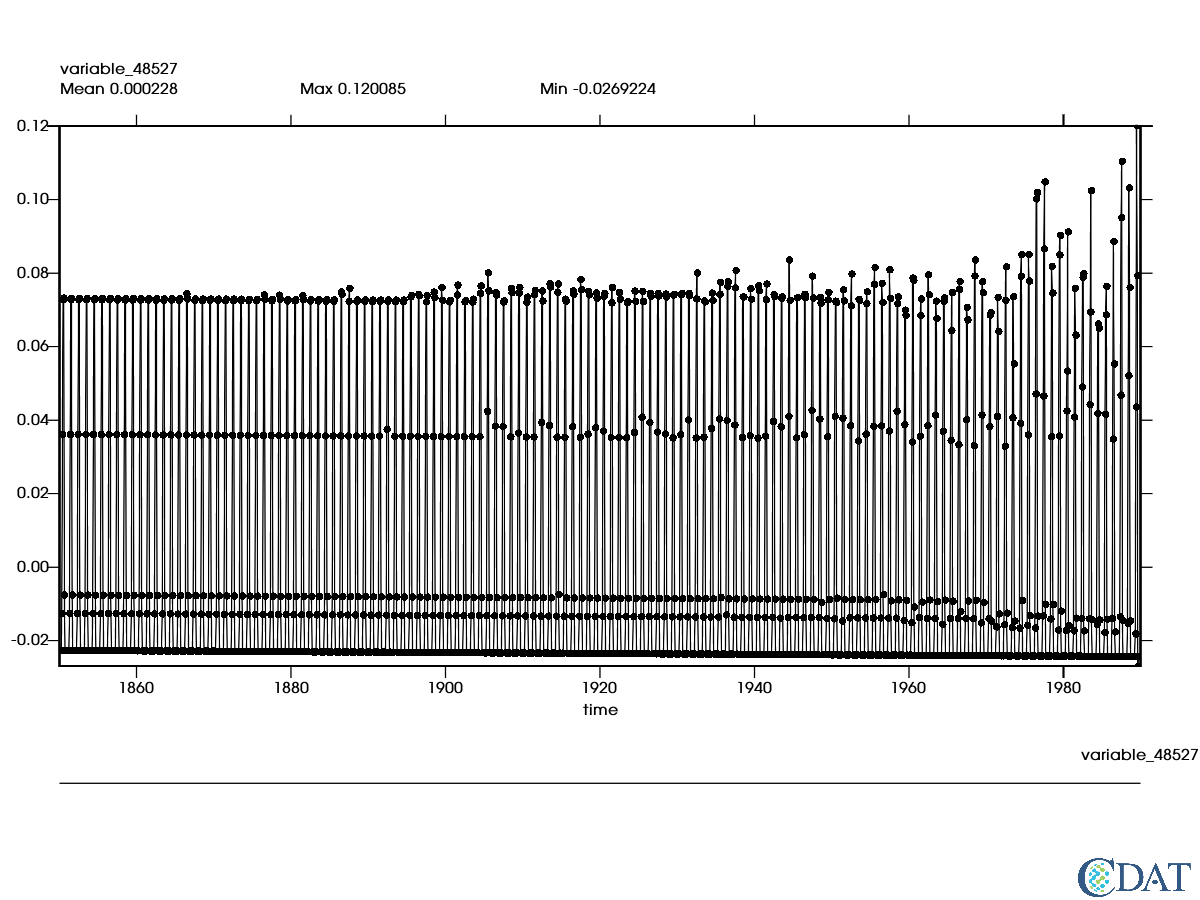

In [65]:
x.clear()
x.plot(datamskd_departures_detrend_ts_corrected - datamskd_departures_ts_corrected_detrend, template)

Although the differences in the time-series produced by Options A & B are mostly much smaller than 0.1 K and an order of magnitude smaller than the anomalies themselves, these differences might nevertheless be important (and could be much larger if larger amounts of data were missing or masked). Which option, then, is to be preferred? The answer is not obvious. Some idealized (and possibly extreme) cases should be analyzed in the context of a particular analysis to determine which might be more appropriate. 

One final note:  there may be better options for detrending data when there are differences in the trend that depend on time of year. Consider, for example, data with large positive trends in the cooler half of the year and large negative trends during the warmer half of the year, such that the trend considering all months of the year together is zero. Detrending this data following the two approaches above will not modify it at all; the trends for the warm part of the year will remain, as will those in the cold half of the year. If one is interested in the shorter term interannual variability, one might want to remove these seasonally dependent trends. One might, for example, extract all the January's and detrend them, and do the same for each subsequent month. Then the anomalies could be reassembled to cover the full time series, and the trends would also have been removed in both the warmer and cooler times of year.


***

[Back to Top](#top)

The CDAT software was developed by LLNL. This tutorial was written by Charles Doutriaux, Holly Davis, and Karl Taylor. This work was performed under the auspices of the U.S. Department of Energy by Lawrence Livermore National Laboratory under Contract DE-AC52-07NA27344.

If you have questions about this notebook, please email our [CDAT Support](cdat-support@llnl.gov) address, cdat-support@llnl.gov.